# Monitor optimisations

This notebook will show how to check the status of the optimisations while they are running.

It is important to do so as optimisation often do not behave as expected or crash. Noticing that early on alllows to stop the optimisations early and avoid losing time and compute resources.

In [1]:
import pickle
import glob
import numpy
import json
import matplotlib.pyplot as plt
from bluepyemodel.access_point.access_point import OptimisationState
from bluepyemodel.access_point.local import LocalAccessPoint

IMPORTANT: Please populate the following parameters with the relevant values utilized:

In [2]:
emodel = "L5PC"
githash = "YOUR_GITHASH_HERE"
species = "rat"
brain_region = "SSCX"

In [3]:
if githash is None:
    emodel_dir = "."
else:
    emodel_dir = f"./run/{githash}"

access_point = LocalAccessPoint(
    emodel=emodel,
    final_path="./final.json",
    species = species,
    brain_region = brain_region,
    emodel_dir=emodel_dir,
    iteration_tag=githash,
    recipes_path='./config/recipes.json',
)

The following cell will read all the optimisation checkpoints matching the githash and display the current state of the optimisation:

Seed: 1, Generation: 101, status: completed, Score: 155.23798035814588
Seed: 2, Generation: 101, status: completed, Score: 146.25993262641236
Seed: 5, Generation: 101, status: completed, Score: 153.00489261155812
Seed: 4, Generation: 101, status: completed, Score: 148.44684437319347
Seed: 3, Generation: 101, status: completed, Score: 140.53797968139085
Best fitness: 140.53797968139085 from checkpoint ./checkpoints/L5PC/cb048ae/emodel=L5PC__species=rat__brain_region=SSCX__iteration=cb048ae__seed=3.pkl


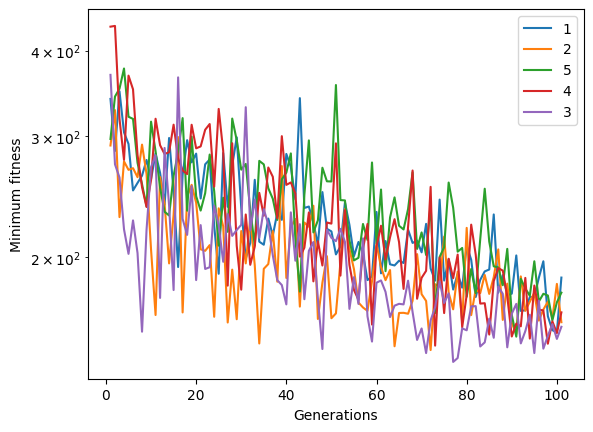

In [4]:
best_fitness = []
if githash is None:
    paths = glob.glob(f"./checkpoints/{emodel}/*.pkl", recursive=True)
else:
    paths = glob.glob(f"./checkpoints/{emodel}/{githash}/*.pkl", recursive=True)

if not paths:
        print("No checkpoints found.")

for path in paths:
    with open(path, "rb") as file:
        data = pickle.load(file)
    seed = path.split("_seed=")[1].split(".pkl")[0]
    generation = data["logbook"].select("gen")[-1]
    best_score = sum(data["halloffame"][0].fitness.values)
    opt_state = access_point.optimisation_state(seed, continue_opt=True)
    if opt_state == OptimisationState.COMPLETED:
        status = "completed"
    elif opt_state == OptimisationState.IN_PROGRESS:
        status = "in progress"
    elif opt_state == OptimisationState.EMPTY:
        print(f"No checkpoint found for species: {species}, brain_region: {brain_region}")
        continue
    else:
        status = "unknown"
    print(f"Seed: {seed}, Generation: {generation}, Status: {status}, Score: {best_score}")
    plt.plot(data["logbook"].select("gen"), data["logbook"].select("min"), label=seed)
    best_fitness.append(best_score)

if best_fitness:
    print(f"Best fitness: {min(best_fitness)} from checkpoint {paths[numpy.argmin(best_fitness)]}")

plt.xlabel("Generations")
plt.ylabel("Minimum fitness")
plt.yscale("log")
plt.legend(loc='upper right')
plt.show()